In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.providers.basic_provider import BasicProvider
import numpy as np
from numpy import pi
import qiskit.quantum_info as qi
import math
from enum import Enum
from qiskit.quantum_info import Statevector
import unittest


# 1 Noise Model

A standard way to represent the noise in a quantum circuit is through Pauli operators (x, y, z). Build a function with input ,  and QuantumCircuit where:

alpha → Probability of having a random Pauli operator acting on the qubit after a one-qubit gate

beta → Probability of having a random Pauli operator acting on the qubit after a two-qubit gate

QuantumCircuit → Quantum circuit where the noise will be added

The output should be the Quantum Circuit with Noise


In [2]:
def get_choice(probability):
    """
    Get either 0 with 1 - probability and 1 with probability
    """
    return np.random.choice(2, 1, p=[1-probability, probability])[0]
class NoisyQubit(Enum):
    """
    In 2 qubit gate, which qubit(s) should have the noise added
    """
    TARGET = 1
    CONTROL = 2
    CONTROL_TARGET = 3

## Test method do get 1 and 0

In [3]:
shots = 1000
for p in np.arange(0, 1.1, 0.1):
    ones = np.sum([get_choice(p) for _ in range(shots)])/shots
    np.testing.assert_almost_equal(ones, p, 1)

## Method to add noise 

Currently we default to add noise only on target

In [4]:
def add_noise(alpha:float, beta:float, circuit:QuantumCircuit, noisy:NoisyQubit=NoisyQubit.TARGET) -> QuantumCircuit:
  """
  Add noise to a quantum circuit
  :param alpha: Probability of having a random Pauli operator acting on the qubit after a one-qubit gate
  :param beta: Probability of having a random Pauli operator acting on the qubit after a two-qubit gate
  :param circuit: Quantum circuit where the noise will be added
  :param noisy: Noisy qubit
  :return: Quantum circuit with noise
  """
  instructions = circuit.data
  pauly_str = ['X', 'Y', 'Z']
  circuit_noisy = QuantumCircuit(*circuit.qregs, *circuit.cregs)
  for instruction in circuit.data:
    circuit_noisy.append(instruction)
    if instruction.operation.name not in  ['reset', 'measure']:
      if len(instruction.qubits) == 1:
        if get_choice(alpha) == 1:
          pauly_index = np.random.choice(pauly_str)
          circuit_noisy.pauli(pauly_index, [instruction.qubits[0]])
      elif len(instruction.qubits) == 2:
        if get_choice(beta) == 1:
          pauly_index = np.random.choice(pauly_str)
          if noisy == NoisyQubit.CONTROL:
            circuit_noisy.pauli(pauly_index, [instruction.qubits[0]])
          elif noisy == NoisyQubit.TARGET:
            circuit_noisy.pauli(pauly_index, [instruction.qubits[1]])
          elif noisy == NoisyQubit.CONTROL_TARGET:
            circuit_noisy.pauli(pauly_index, [instruction.qubits[0]])
            circuit_noisy.pauli(pauly_index, [instruction.qubits[1]])
  return circuit_noisy




## Create a circuit to add noise later

In [5]:
num_bits_a = 3
qreg_a = QuantumRegister(num_bits_a, 'qa')
creg_a = ClassicalRegister(num_bits_a, 'ca')
circuit = QuantumCircuit(qreg_a, creg_a)
for i in range(num_bits_a):
  circuit.reset(qreg_a[i])
circuit.x(qreg_a[0])
circuit.cx(qreg_a[1], qreg_a[0])
circuit.cp(np.pi/2, qreg_a[1], qreg_a[0])
for i in range(num_bits_a):
  circuit.measure(qreg_a[i], creg_a[i])
circuit.draw()

┌───┐┌───┐         ┌─┐   
qa_0: ─|0>─┤ X ├┤ X ├─■───────┤M├───
           └───┘└─┬─┘ │P(π/2) └╥┘┌─┐
qa_1: ─|0>────────■───■────────╫─┤M├
            ┌─┐                ║ └╥┘
qa_2: ─|0>──┤M├────────────────╫──╫─
            └╥┘                ║  ║ 
ca: 3/═══════╩═════════════════╩══╩═
             2                 0  1

## Adding noise to above circuit

In [6]:
alpha = .5
beta = .3
circuit_noisy = add_noise(alpha, beta, circuit)
circuit_noisy.draw()

┌───┐┌──────────┐┌───┐         ┌─┐   
qa_0: ─|0>─┤ X ├┤ Pauli(X) ├┤ X ├─■───────┤M├───
           └───┘└──────────┘└─┬─┘ │P(π/2) └╥┘┌─┐
qa_1: ─|0>────────────────────■───■────────╫─┤M├
            ┌─┐                            ║ └╥┘
qa_2: ─|0>──┤M├────────────────────────────╫──╫─
            └╥┘                            ║  ║ 
ca: 3/═══════╩═════════════════════════════╩══╩═
             2                             0  1

# 2 Gate Basis 

Quantum computers can implement only a set of gates that, with transformations, can represent any other possible gate. This set of gates is called the Gate Basis of the QPU. Build a function that transforms a general Quantum Circuit to the following gate basis: {CX,ID,RZ,SX,X}


In [7]:
def transform_to_basis(circuit):
  """Transforms a quantum circuit to the basis {CX, ID, RZ, SX, X}.

  :param circuit: The input quantum circuit.
  :return: The transformed quantum circuit.
  """
  transformed_circuit = QuantumCircuit(*circuit.qregs, *circuit.cregs)

  def pauli_x(input_circuit, qubit):
    input_circuit.x(qubit) # X
    return input_circuit

  def pauli_y(input_circuit, qubit):
    input_circuit.rz(np.pi, qubit)  # RZ(pi)
    input_circuit.x(qubit)  # X

    return input_circuit

  def pauli_z(input_circuit, qubit):
    input_circuit.rz(np.pi, qubit)  # RZ(pi)
    return input_circuit

  for instruction in circuit.data:
      qargs = instruction.qubits
      cargs = instruction.clbits
      if instruction.operation.name == 'h':  # Hadamard
          transformed_circuit.rz(np.pi / 2, qargs[0])  # RZ(pi/2)
          transformed_circuit.sx(qargs[0])  # SX
          transformed_circuit.rz(np.pi / 2, qargs[0])  # RZ(pi/2)
      elif instruction.operation.name == 'ry':  # Rotation around Y-axis
          transformed_circuit.sx(qargs[0])  # SX
          transformed_circuit.rz(instruction.params[0] + np.pi, qargs[0])  # RZ(theta)
          transformed_circuit.sx(qargs[0])  # SX
          transformed_circuit.rz(3*np.pi, qargs[0])  # RZ(theta)
      elif instruction.operation.name == 'cp':  # Controlled Rotation around Z-axis
          transformed_circuit.rz(instruction.params[0]/2, qargs[0])  # RZ(angle) on control bit
          transformed_circuit.cx(qargs[0], qargs[1])  # CX(control, target)
          transformed_circuit.rz(-instruction.params[0]/2, qargs[1])  # RZ(-angle) on target bit
          transformed_circuit.cx(qargs[0], qargs[1])  # CX(control, target)
          transformed_circuit.rz(instruction.params[0]/2, qargs[1])  # RZ(angle) on target bit

      elif instruction.operation.name == 'rx':  # Rotation around X-axis
          transformed_circuit.rz(np.pi/2, qargs[0]) # RZ(pi/2)
          transformed_circuit.sx(qargs[0])  # SX
          transformed_circuit.rz(instruction.params[0] + np.pi, qargs[0]) # RZ(angle)
          transformed_circuit.sx(qargs[0])  # SX
          transformed_circuit.rz(5*np.pi/2, qargs[0]) # RZ(-pi/2)
      elif instruction.operation.name == 'pauli':  # Rotation around X-axis
          for param, qubit in zip(instruction.params[0][:], reversed(qargs)):
              if param == 'X':
                  transformed_circuit = pauli_x(transformed_circuit, qubit)
              elif param == 'Y':
                  transformed_circuit = pauli_y(transformed_circuit, qubit)
              elif param == 'Z':
                  transformed_circuit = pauli_z(transformed_circuit, qubit)
      elif instruction.operation.name in ['reset', 'measure', 'cx', 'id', 'rz', 'sx', 'x']:
          # These gates are already in the target basis
          transformed_circuit.append(instruction, qargs, cargs)
      else:
          raise ValueError(f"Unsupported gate: {instruction.operation.name}")

  return transformed_circuit

In [8]:
qreg_a = QuantumRegister(3, 'qa')
phi = Parameter('phi')
circuit = QuantumCircuit(qreg_a)
#circuit.pauli('YXZ', [qreg_a[0], qreg_a[1], qreg_a[2]])
#circuit.h(qreg_a[0])
#circuit.ry(phi, qreg_a[0])
circuit.cp(phi, qreg_a[0], qreg_a[1])
#circuit.rx(phi, qreg_a[0])
circuit.draw()


qa_0: ─■───────
       │P(phi) 
qa_1: ─■───────
               
qa_2: ─────────

In [9]:
transform_to_basis(circuit).draw()

┌───────────┐                                     
qa_0: ┤ Rz(phi/2) ├──■──────────────────■───────────────
      └───────────┘┌─┴─┐┌────────────┐┌─┴─┐┌───────────┐
qa_1: ─────────────┤ X ├┤ Rz(-phi/2) ├┤ X ├┤ Rz(phi/2) ├
                   └───┘└────────────┘└───┘└───────────┘
qa_2: ──────────────────────────────────────────────────

# 3 Adding two numbers with a quantum computer

Build a function (quantum_sum) to add two numbers using the Draper adder algorithm. You will need the Quantum Fourier Transform (QFT). Many libraries offer a function to use it. For this task, you will need to build QFT from scratch.


### Helper method to convert back from two's complement

In [10]:
# code from: https://stackoverflow.com/questions/1604464/twos-complement-in-python
def twos_comp(val, bits):
    """compute the 2's complement of int value val"""
    if (val & (1 << (bits - 1))) != 0: # if sign bit is set e.g., 8bit: 128-255
        val = val - (1 << bits)        # compute negative value
    return val                         # return positive value as is


sum_circuit returns a Quantum circuit which uses Draper's algorithm to add two input number. Expectation is that an input circuit is provided with a and b quantum registers. As one can see that in sum_circuit no resolution need to be provided for a and b though input circuit needs to be appropriately established to account for expected resolution.

In [2]:
def init_circuit(a, b):
    """
    Create a quantum circuit based on the provided values of a and b
    """
    assert len(a) == len(b)
    NUM_BITS = len(a) 
    qreg_a = QuantumRegister(NUM_BITS, 'a')
    qreg_b = QuantumRegister(NUM_BITS, 'b')
    regs = [qreg_a, qreg_b]
    circuit = QuantumCircuit(*regs)
    # Set the bits based on bit string  
    for i in range(NUM_BITS):
        circuit.reset(qreg_a[i])
        bit_index = NUM_BITS - i - 1
        if bit_index < NUM_BITS and bit_index >= 0 and a[bit_index] == '1':
          circuit.x(qreg_a[i])
    for i in range(NUM_BITS):
        circuit.reset(qreg_b[i])
        bit_index = NUM_BITS - i - 1
        if bit_index < NUM_BITS and bit_index >= 0  and b[bit_index] == '1':
          circuit.x(qreg_b[i])
    return circuit

def get_reg_by_name(regs, name):
    for reg in regs:
        if reg.name == name:
            return reg
    return None
    
def sum_circuit(circuit):
    """
    Returns a circuit which sums the Quantum Register a and b. If Classical Register a is present than measure Quantum Register in that
    """
    qreg_a = get_reg_by_name(circuit.qregs, 'a')
    qreg_b = get_reg_by_name(circuit.qregs, 'b')
    # Currently both Quantum Register have to be same size
    assert qreg_a.size == qreg_b.size
    NUM_BITS = qreg_a.size

    # QFT
    for i in reversed(range(NUM_BITS)):
        circuit.h(qreg_a[i])
        k = 2
        for j in range(i-1, -1, -1):
          circuit.cp(2*pi/math.pow(2, k), qreg_a[j], qreg_a[i])
          k+=1

    # Add numbers using phase
    for i in reversed(range(NUM_BITS)):
        k = 1
        for j in reversed(range(NUM_BITS)):
          if j <= i:
            circuit.cp(2*pi/math.pow(2, k), qreg_b[j], qreg_a[i])
            k+=1

    # IQFT
    for i in range(NUM_BITS):
        k = 1 + len(list(reversed(range(i-1, -1, -1))))
        for j in reversed(range(i-1, -1, -1)):
          circuit.cp(-2*pi/math.pow(2, k), qreg_a[j], qreg_a[i])
          k-=1
        circuit.h(qreg_a[i])
    return circuit

def quantum_sum(a, b,  NUM_BITS=4, transform_function=None, noise_function = None, alpha= None, beta=None):
    
    a_binstring = format(a if a >= 0 else (1 << NUM_BITS) + a, f'0{NUM_BITS}b')
    b_binstring = format(b if b >= 0 else (1 << NUM_BITS) + b, f'0{NUM_BITS}b')
    circuit = sum_circuit(init_circuit(a_binstring, b_binstring))
    if transform_function:
        circuit = transform_function(circuit)
    if noise_function:
        assert alpha is not None
        assert beta is not None
        circuit = noise_function(alpha, beta, circuit)
    stv = Statevector(circuit)
    states = []
    for state, amp in enumerate(stv.data):
          if not np.isclose(amp, 0):
              states.append(twos_comp(int(f"{state:0{stv.num_qubits}b}"[NUM_BITS:],2), NUM_BITS))
    return states, circuit
    


### Test addition for 4 bit numbers. 

Discarding the cases when overflow happens. It should be accounted by setting the circuit appropriately for higher NUM_BITS

In [12]:
NUM_BITS = 4
max_num = np.power(2, NUM_BITS-1)
range_nums = list(range(-np.power(2, NUM_BITS) + max_num, max_num, 1))
for i in range_nums:
  for j in range_nums:
    if i + j in range_nums: #discarding cases when there is overflow
      states, circuit = quantum_sum(i, j, NUM_BITS)
      assert len(states) == 1
      assert states[0] == i + j


### Test addition for 4 bit numbers along with tansformation to basis 

In [13]:
NUM_BITS = 4
max_num = np.power(2, NUM_BITS-1)
range_nums = list(range(-np.power(2, NUM_BITS) + max_num, max_num, 1))
for i in range_nums:
  for j in range_nums:
    if i + j in range_nums: #discarding cases when there is overflow
      states, circuit = quantum_sum(i, j, NUM_BITS, transform_function=transform_to_basis)
      assert len(states) == 1
      assert states[0] == i + j


# 4 Effects of noise on quantum addition 

Now, we can combine all the functions. Transform the circuit used in the quantum_sum to the gate basis and add noise. Use different levels of noise and analyze the results. 

●	How does the noise affect the results?

●	Is there a way to decrease the effect of noise? 

●	How does the number of gates used affect the results? 


In [58]:
noise = [x/100.0 for x in range(0, 101, 25)]

def get_results_for_bits(NUM_BITS, noise, shots=1):
    max_num = np.power(2, NUM_BITS-1)
    range_nums = list(range(-np.power(2, NUM_BITS) + max_num, max_num, 1))
    results = []
    alpha_noise_values = noise
    beta_noise_values = noise
    for alpha_noise in alpha_noise_values:
      result = []
      for beta_noise in beta_noise_values:
        counts = 0
        passed = 0
        for i in range_nums:
          for j in range_nums:
            if i + j in range_nums: #discarding cases when there is overflow
                for _ in range(shots):
                    counts += 1
                    states, circuit = quantum_sum(i, j, NUM_BITS, transform_function=transform_to_basis, noise_function=add_noise, alpha=alpha_noise, beta=beta_noise)
                    if len(states) == 1 and  states[0] == i + j:
                        passed += 1
        result.append(passed/counts)
      results.insert(0,result)
    return results

### Test addition for 4 bit numbers along with tansformation to basis along with random noise

In [49]:
results = get_results_for_bits(4, noise)

[Text(0.5, 23.52222222222222, 'Alpha'), Text(50.722222222222214, 0.5, 'Beta')]

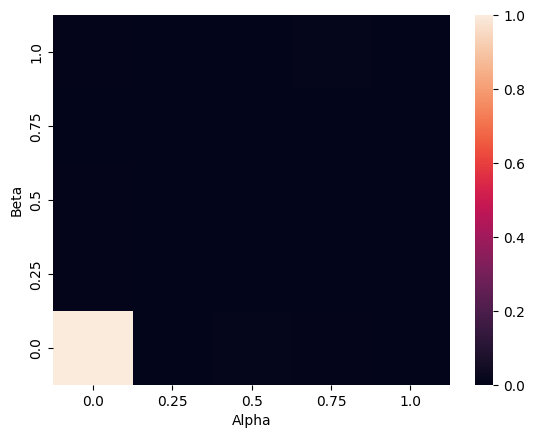

In [52]:
import seaborn as sns
hm = sns.heatmap(results, xticklabels=noise, yticklabels=list(reversed(noise)))
hm.set(xlabel='Alpha', ylabel='Beta')

### Test addition for 2 bit numbers along with tansformation to basis along with random noise

In [69]:
results = get_results_for_bits(2, noise, 10)

[Text(0.5, 23.52222222222222, 'Alpha'), Text(50.722222222222214, 0.5, 'Beta')]

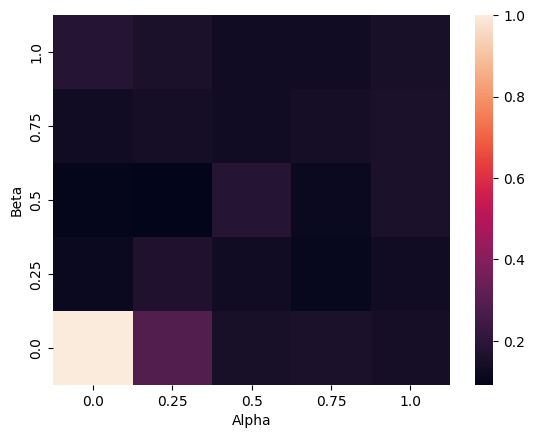

In [70]:
import seaborn as sns
hm = sns.heatmap(results, xticklabels=noise, yticklabels=list(reversed(noise)))
hm.set(xlabel='Alpha', ylabel='Beta')

### Test addition for 1 bit numbers along with tansformation to basis along with random noise

In [71]:
results = get_results_for_bits(1, noise, 10)

[Text(0.5, 23.52222222222222, 'Alpha'), Text(50.722222222222214, 0.5, 'Beta')]

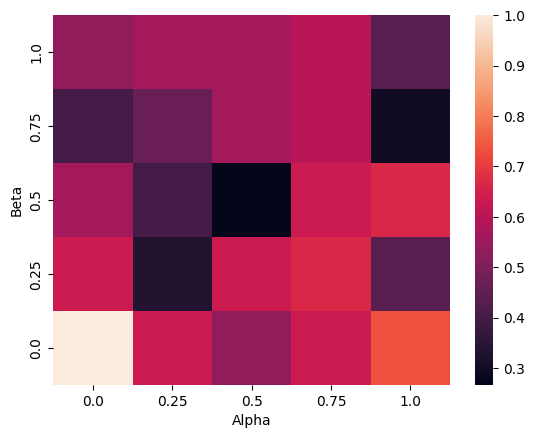

In [72]:
import seaborn as sns
hm = sns.heatmap(results, xticklabels=noise, yticklabels=list(reversed(noise)))
hm.set(xlabel='Alpha', ylabel='Beta')

●	How does the noise affect the results?

As we increase the noise results become less reliable.

●	Is there a way to decrease the effect of noise? 

●	How does the number of gates used affect the results?

Higher number of gates would be more prone to noise hence we see really bad results when we are adding 4 bit numbers compared to 1 bit